## Automatic Differentiation from Scratch

This demo is based on Boaz Barak's excellent [Yet another backpropagation tutorial](https://windowsontheory.org/2020/11/03/yet-another-backpropagation-tutorial/). I highly recommend reading through it if you would like more detail or explanation.

I find the following image (from Barak's tutorial) a great way of visualizing the high level idea of backpropagation.

<img src="https://windowsontheory.files.wordpress.com/2021/12/backprop.png" width="500">

An accessible proof of the multivariate chain rule appears [here](https://math.libretexts.org/Bookshelves/Calculus/Book%3A_Calculus_(OpenStax)/14%3A_Differentiation_of_Functions_of_Several_Variables/14.05%3A_The_Chain_Rule_for_Multivariable_Functions).

We'll start by implementing automatic differentiation from scratch. We build a class `Value` which holds a single scalar and encodes the relationship between the scalar and the scalars which created the scalar ("children"). Assuming we know how to find the gradient of each scalar (which will implement soon), the `backward` method is used to compute the gradient of the scalar and then all its children.

In [1]:
class Value:
  ''' stores a single scalar and its gradient '''
  def __init__(self, data, _children=()):
    self.data = data
    self.grad = 0
    self._backward = lambda : None
    self._prev = set(_children)
    
  def backward(self, visited=None):
    if visited is None:
      visited = set([self])
      self.grad = 1
    self._backward()
    for child in self._prev:
      if not child in visited:
        visited.add(child)
        child.backward(visited)


Next, we'll add methods to `Value` which describe how to calculate operations and, crucially, the gradient when `backward` is called.

Can you see why the output `out` from the addition method has the value and children it does? And why the gradients in the `_backward` method are what they are? Using the addition method as a template, we will fill in the methods for the multiplication, power, and ReLU operations.

In [2]:
def __add__(self, other):
  other = other if isinstance(other, Value) else Value(other)
  out = Value(self.data + other.data, [self, other])

  def _backward():
    self.grad += out.grad
    other.grad += out.grad    
  out._backward = _backward

  return out

setattr(Value, '__add__', __add__)

def __mul__(self, other):
  
  other = other if isinstance(other, Value) else Value(other)
  out = Value(self.data * other.data, [self, other])

  def _backward():
    self.grad += out.grad * other.data
    other.grad += out.grad * self.data    
  out._backward = _backward

  return out

setattr(Value, '__mul__', __mul__)

def __pow__(self, other):
  
  out = Value(self.data ** other, [self])

  def _backward():
    self.grad += out.grad * self.data ** (other-1) * other
  out._backward = _backward

  return out

setattr(Value, '__pow__', __pow__)


def relu(self):
  
  out = Value(0 if self.data < 0 else self.data, [self])

  def _backward():
      self.grad += (out.data > 0) * out.grad
  out._backward = _backward

  return out

setattr(Value, 'relu', relu)

def __sub__(self, other): return self + (-other)
setattr(Value, '__sub__', __sub__)
def __rsub__(self, other): return self + (-other)
setattr(Value, '__rsub__', __rsub__)
def __rmul__(self, other): return self * other
setattr(Value, '__rmul__', __rmul__)
def __radd__(self, other): return self + other
setattr(Value, '__radd__', __radd__)

Notice that we add additional methods for built-in operations to make addition and subtraction easier. The `setattr` method is used to methods to the class `Value` after it's already been defined.

## Neural Network from Scratch

Now that we have a method for differentiating scalars,
the next problem is to build a neural network. We will do so iteratively to keep the code clean. The first part is a single layer. In our implementation, a layer will consist of weights connecting each node in the input to every node in the output. If the `add_relu` flag is on, then the nodes in the output will have a ReLU activation applied to them. We show you how to initialize the layer implement the `__call__` method.

In [3]:
import random

class Layer:
  def __init__(self, input_size, output_size, add_relu = True):
    self.input_size = input_size
    self.output_size = output_size
    self.add_relu = add_relu
    self.weights = [[Value(random.gauss(0, 1/max(input_size, output_size))) for _ in range(input_size)] for _ in range(output_size)]
    self.biases = [Value(random.gauss(0, 1/max(input_size, output_size))) for _ in range(output_size)]

  def __call__(self, inputs):
    
    y = [sum(w * x for w, x in zip(weights, inputs)) for weights in self.weights]
    y = [yi + b for yi, b in zip(y, self.biases)]
    if self.add_relu:
      y = [y.relu() for y in y]
    return y



Notice how the weights are initialized to normal variables with mean 0 and variance 1/max(input_size, output_size). This choice is to prevent gradients from becoming too large or too small.

Next, we'll use our `Layer` class to build the `Network` class. This class will hold the layers and be responsible for combining the layers to produce the prediction, updating the weights with the gradient, and zero-ing the gradient after each update.

In [4]:

class Network:
  def __init__(self, *layers):
    self.layers = layers
    self.parameters = []
    for layer in self.layers:
      for sublayer in layer.weights:
        self.parameters += sublayer
      self.parameters += layer.biases
  
  def update(self, learning_rate):
    
    for p in self.parameters:
      p.data -= p.grad * learning_rate

  def zero_grad(self):
    
    for p in self.parameters:
      p.grad = 0

  def __call__(self, x):
    
    y = x
    for layer in self.layers:
      y = layer(y)
    return y

Now that we have our network, we'll take a look at our data. The training set consists of 404 houses each with 13 features.

In [5]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(path='boston_housing.npz')

print('The dimension of the data are', x_train.shape, '\n')

65536/57026 [==================================] - 0s 0us/step
The dimension of the data are (404, 13) 



So the input size of our model should be 13 so we can take the features of each house as input. The output is a real-valued prediction (in thousands) for the value of the house. Initially, we will get random numbers from our model (as we should since we initialized the weights randomly). The loss is the mean squared error (MSE) between the predicted value and the actual value of the house.

In [6]:
model = Network(Layer(13, 10), Layer(10, 10), Layer(10, 1, add_relu = False))
# We don't apply ReLU on the last layer

import numpy as np

num_epochs = 10
learning_rate = .0001
train_losses = []
test_losses = []
for epoch in range(num_epochs):  
  # Training
  loss = 0
  for x,y in zip(x_train, y_train):
    
    yhat = model(x.flatten())[0]
    loss += (y-yhat)**2
    #
  loss *= 1/len(x_train)
  
  loss.backward()
  model.update(learning_rate)
  model.zero_grad()
  # 
  train_losses += [loss.data]
  # Validation
  loss = 0
  for x,y in zip(x_test, y_test):
    
    yhat = model(x.flatten())[0]
    loss += (y-yhat)**2
    #
  loss *= 1/len(x_test)
  test_losses += [loss.data]

Now that we've trained our model, let's take a look at the training loss and validation loss by iteration.

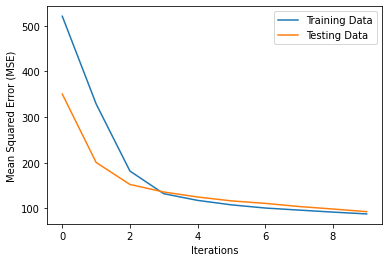

In [7]:
import matplotlib.pyplot as plt

iterations = list(range(len(train_losses)))
plt.plot(iterations, train_losses, label='Training Data')
plt.plot(iterations, test_losses, label='Testing Data')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Iterations')
plt.legend()

Your loss should drop from around five hundred to around one hundred, taking about a minute to run 10 epochs. Our implementation of a neural network is incredibly inefficient. So from now on, we'll use optimized libraries to run the operations we developed in this notebook.

Your testing loss should initially be lower than the training loss, why? As the number of iterations increase, why does the training loss outperform the testing loss?

The previous plot is a little abstract. So take some time to play around with individual houses and inspect the difference from the predicted value and the actual value.

In [14]:
i = 50
x, y = x_test[i], y_test[i]
print(y)
print(x)
print(model(x)[0].data)

35.4
[1.3110e-02 9.0000e+01 1.2200e+00 0.0000e+00 4.0300e-01 7.2490e+00
 2.1900e+01 8.6966e+00 5.0000e+00 2.2600e+02 1.7900e+01 3.9593e+02
 4.8100e+00]
22.815686500618067
